# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Dynamics of Disease Transmission and Human Behavior Project
## CS109B: Advanced Topics in Data Science



**Harvard University**<br/>
**Spring 2022**<br/>
**Team members**: Di Zhen, Yujie Zhang, and Xinyun Stacy Li


<hr style="height:2pt">

# 1. Introduction
COVID-19 has caused a global impact since its outbreak in 2019. Various of efforts have been spent to predict and prevent the transmission of the virus. Some conducted time-series predicting of COVID-19 cases and deaths based on daily confirmed cases and deaths using deep neural network (Alassafi, Madini O et al., 2022). Others also incorporated features indicating human interactions, human mobility, and socioeconomic compositions of countries to make the prediction (Vahedi, B., Karimzadeh, M. & Zoraghein, H., 2021). Here in this project, we explored and examined the effectiveness of predicting COVID-19 cases using Google trends. Given its potentially sensitive and fast reaction, Google trend pattern could provide important signals for the following changes in the number of COVID-19 cases and deaths. 


We have two goals to achieve:
1. Use the Google search activity trends data within a certain window to predict the COVID-19 confirmed cases trends.

1. Recognize the complications of COVID-19 through Google search trends. This secondary goal can be achieved by interpreting the model for the first goal and identify important features. 

1. Test the generalizability of the model (cross-states, cross-diseases)

We propose applying neural network models including simple RNN, LSTM, and bidirectional LSTM to predict the confirmed COVID-19 cases for the following 5 days based on the Google trend data within 2 weeks. We focus on predictions for three states including California, New York, and Massachusetts, which are metropolitan representatives of the eastern and western U.S. The large populations in these states provide a clear picture of the transmission pattern of the virus over time. Moreover, we are also interested in the most predictive trends for these states and whether the model built from one state could generalize to the other two states.

In [ ]:
import os
import random as rn
import tensorflow as tf
import pandas as pd
import numpy as np
import missingno as meso
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

# Import class for reservoir computing
# from pyESN import ESN # Written by user cknd: https://github.com/cknd/pyESN
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

# 2. Exploratory Data Analysis (EDA), Data Cleaning, and Feature Selection


The data we are working on contains a set of time-series records spanned nearly two years where each set corresponds to a state. This data is also used by another group for early COVID-19 warning approach (Kogan, Nicole E et al., 2021). The features of the data are mainly Google trends patterns for a suite of COVID-19-related terms. The data also contains dates, JHU confirmed COVID-19 cases, deaths and hospitalization. JHU-cases are the reported COVID-19 cases on the John Hopkins platform. Same with deaths and hospitalizations.

## Load packages and three datasets from California, New York, and Massachusetts


In [ ]:


california = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/California.csv",parse_dates=['date'],index_col=['date'])
new_york = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/New York.csv",parse_dates=['date'],index_col=['date'])
ma = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/Massachusetts.csv",parse_dates=['date'],index_col=['date'])

## Have a glimps of the basic characteristics of the features in three datasets

In [ ]:
california.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,544.000000,416.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,8408.796657,107.302228,654.398897,266.588302,1030.704152,266.593229,185.266133,90810.222561,265.852155,28.855214,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,12651.020881,138.156802,557.909209,194.928115,1386.217145,344.922148,256.649861,48820.246092,265.981913,55.806597,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,-3935.000000,-364.000000,116.000000,0.305869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,1808.000000,25.000000,321.000000,148.166794,0.000000,0.000000,0.000000,59647.616821,85.325358,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,4261.500000,71.000000,432.500000,218.744994,485.108779,106.145011,75.977969,85948.450560,203.427506,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,9263.500000,126.000000,767.250000,372.607233,1539.188000,426.497571,301.896027,120890.000707,350.524237,74.825872,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,133669.000000,1174.000000,2580.000000,1038.286656,7638.661166,2015.938064,1288.312759,279350.860227,1762.854735,489.629451,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
new_york.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,628.000000,413.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,5650.603064,84.179666,338.020701,273.848046,1040.674234,257.207644,185.460069,82087.413030,243.897693,29.128731,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,10578.020047,158.428439,346.426180,204.442332,1436.859569,368.775430,273.028401,45329.143270,281.842701,99.272875,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,0.000000,-39.000000,0.000000,0.386998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,761.250000,11.000000,76.750000,119.990235,0.000000,0.000000,0.000000,54615.949432,0.000000,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,3244.000000,33.000000,248.000000,212.882174,470.200701,121.905797,0.000000,76345.196625,165.008906,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,6820.250000,85.750000,501.000000,429.083090,1480.176445,382.610327,319.808007,111991.856015,352.887232,0.000000,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,132093.000000,1271.000000,1822.000000,851.288126,7497.319619,1960.105672,1492.312072,252855.272209,1658.316674,1688.992891,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
ma.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,545.000000,405.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,1782.629526,28.646240,95.385321,205.606450,1258.098183,319.416758,179.750699,106088.509550,292.139462,34.961656,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,3216.080237,38.875802,84.255750,152.465206,1975.766136,536.915170,386.783776,55221.448822,439.284028,141.766391,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,-280.000000,-41.000000,0.000000,0.641865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,177.000000,4.000000,33.000000,86.110279,0.000000,0.000000,0.000000,74130.670458,0.000000,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,844.500000,16.000000,71.000000,158.658515,402.440352,0.000000,0.000000,104146.528351,0.000000,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,2104.250000,37.750000,114.000000,331.885371,1672.983884,533.674160,0.000000,136865.778288,524.645158,0.000000,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,33090.000000,302.000000,415.000000,733.953110,11797.230235,3703.701740,2755.424717,326875.861998,2695.132985,1285.819388,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
california.shape, new_york.shape, ma.shape

((744, 498), (744, 498), (744, 498))

## Plot the number of cases, deaths and hospitalizations of COVID-19 against time for each state
In order to visualize the trend of COVID-19 cases from Jan 2020, the beginning of the dataset, to Jan 2022, the end of the dataset, we made the following plots for the three states. We noticed that there were negative numbers of cases in the plot, which were likely to be errors in the record. We changed them to 0s later in the data cleaning.

Text(0.5, 1.0, 'COVID-19 cases varying with time in Massachusetts')

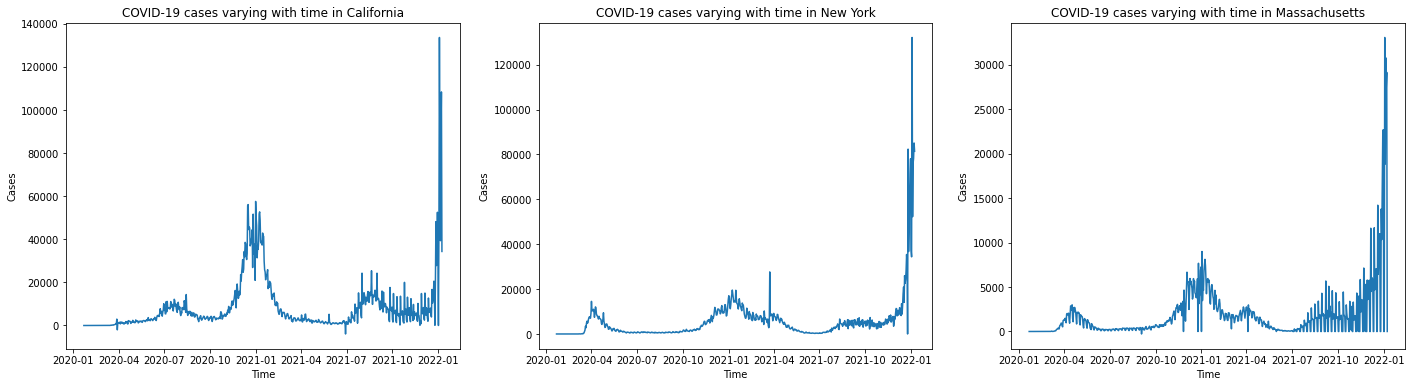

In [ ]:
fig,axs = plt.subplots(1,3, figsize = (24,6))
axs[0].plot(california.index.values, california['JHU_cases'])
axs[1].plot(new_york.index.values, new_york['JHU_cases'])
axs[2].plot(ma.index.values, ma['JHU_cases'])
for i in range(3):
  axs[i].set_xlabel('Time')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[2].set_ylabel('Cases')
axs[0].set_title('COVID-19 cases varying with time in California')
axs[1].set_title('COVID-19 cases varying with time in New York')
axs[2].set_title('COVID-19 cases varying with time in Massachusetts')


## Visualize the distribution of missing values in the features for three states
A bunch of features missing after the first year. We removed them later in the data cleaning since their missingness was too high.

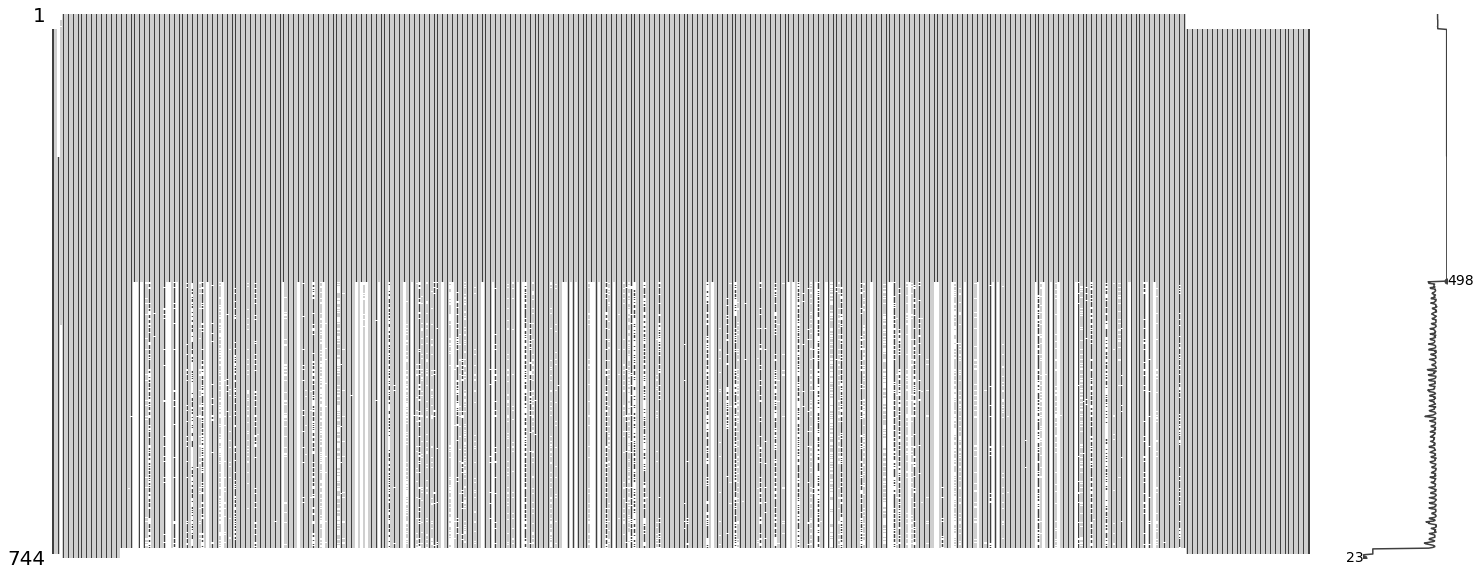

In [ ]:
meso.matrix(california)

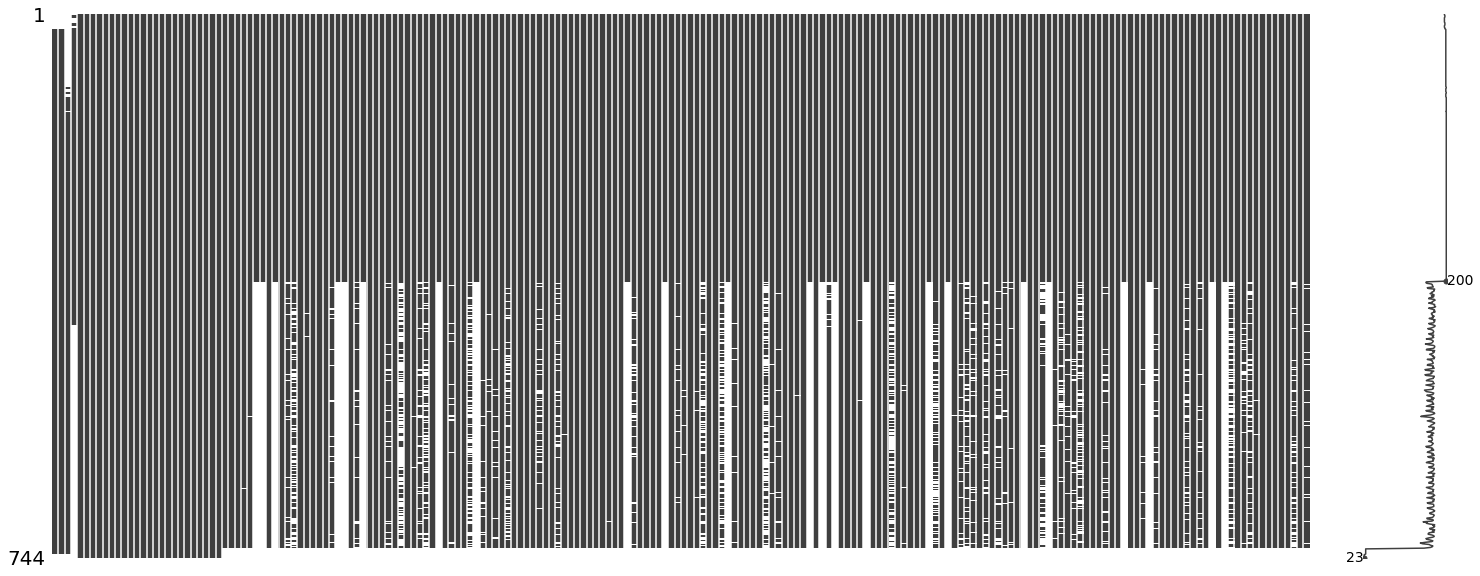

In [ ]:
meso.matrix(new_york.iloc[:,:200])

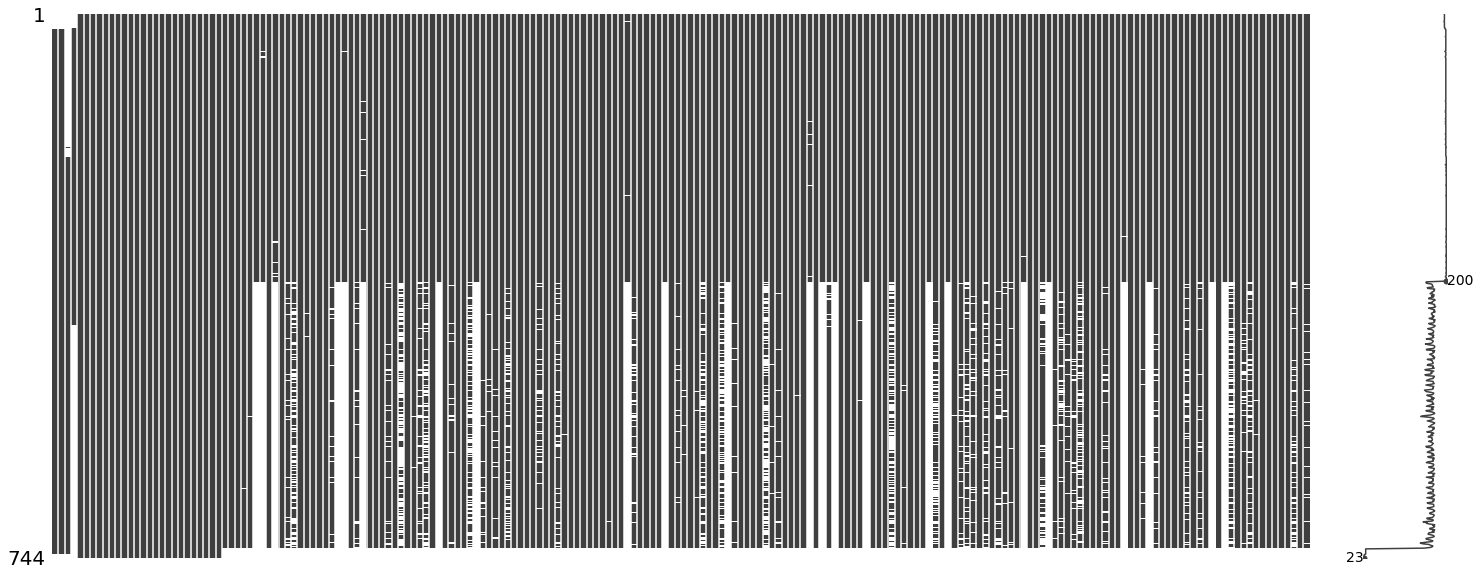

In [ ]:
meso.matrix(ma.iloc[:,:200])


## Drop features with large missing values and round negative cases to 0s

We chose to drop features with more than roughly 20% (100) missing values. After that, we lost 88 features, which wasn't a huge deduction compared to the total number of features we had. We didn't lose a lot of information here.

We observed that most of NAs are at the beginning of the padamic, so we believe the number of cases/deaths are 0 or close to 0. Therefore, we decided to replace nan with 0 in cases/deaths. We also replaced negative number of cases with 0s, because they are likely to be erroneous data.

In [ ]:
for state in [california, new_york, ma]:
  state['JHU_cases']=state['JHU_cases'].fillna(0)
  state['JHU_deaths']=state['JHU_deaths'].fillna(0)
  for col in state.columns:
    if len(state[state[col]<0])>0:
      for row in state[state[col]<0].index:
        state[col][row]=0
    if state[col].isnull().sum()>100:
      state.drop(col,axis=1,inplace=True)

In [ ]:
california.shape, new_york.shape, ma.shape

((744, 410), (744, 410), (744, 410))


## Sanity check the cleaning step by visualization

After data cleaning, we plotted the number of cases of all three states against time to check that all cases were positive and had similar trend.

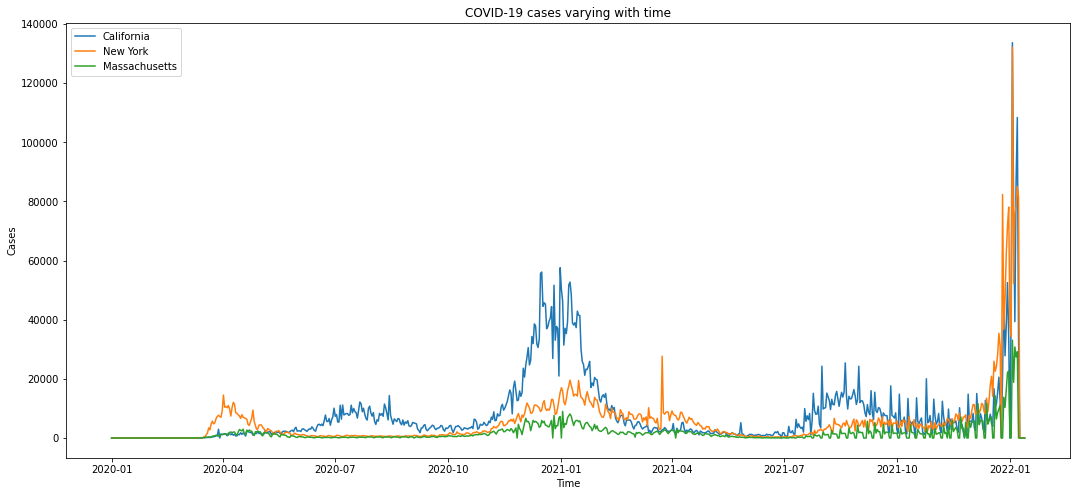

In [ ]:
fig = plt.subplots(1,1, figsize = (18,8))
plt.plot(california.index.values,california['JHU_cases'],label="California")
plt.plot(new_york.index.values,new_york['JHU_cases'],label="New York")
plt.plot(ma.index.values,ma['JHU_cases'],label="Massachusetts")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('COVID-19 cases varying with time')
plt.legend()

## Prepare feature table and smooth data using rolling mean of new cases

We prepared feature table containing only Google Trends. We noticed that the confirmed case data was very ridged. Thus, in order to help the model learn and predict the true trend rather than being distracted by those jagged lines, we smoothed the outcome data using rolling mean of new cases with a window size of 5.

In [ ]:
#separate feature and outcome tables
cali_features=california.iloc[:,2:]
cali_outcomes=california.iloc[:,0]
ny_features=new_york.iloc[:,2:]
ny_outcomes=new_york.iloc[:,0]
ma_features=ma.iloc[:,2:]
ma_outcomes=ma.iloc[:,0]

#extract only google trend features
gt_cols=[]
for col in cali_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
cali_gt=cali_features[gt_cols]

gt_cols=[]
for col in ny_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
ny_gt=ny_features[gt_cols]

gt_cols=[]
for col in ma_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
ma_gt=ma_features[gt_cols]

In [ ]:
# Window == number of days in rolling window over which to calculate mean
window = 5
cali_outcomes = cali_outcomes.transform(lambda x: x.rolling(window).mean())
ny_outcomes = ny_outcomes.transform(lambda x: x.rolling(window).mean())
ma_outcomes = ma_outcomes.transform(lambda x: x.rolling(window).mean())

## Standardize the cases based on the population in the three states

**After standardization, the unit of our outcome became cases/1e5 people.**

Population data referred to: Bureau, US. "State Population Totals And Components Of Change: 2020-2021". Census.Gov, 2022, https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html.

In [ ]:
cali_outcomes=cali_outcomes.apply(lambda x: x*100000/39499738)
ny_outcomes=ny_outcomes.apply(lambda x: x*100000/20154933)
ma_outcomes=ma_outcomes.apply(lambda x: x*100000/7022220)

## Sanity check smoothing & standardization step by visualization

We plotted the number of cases for three states against time after smoothing and standardization.

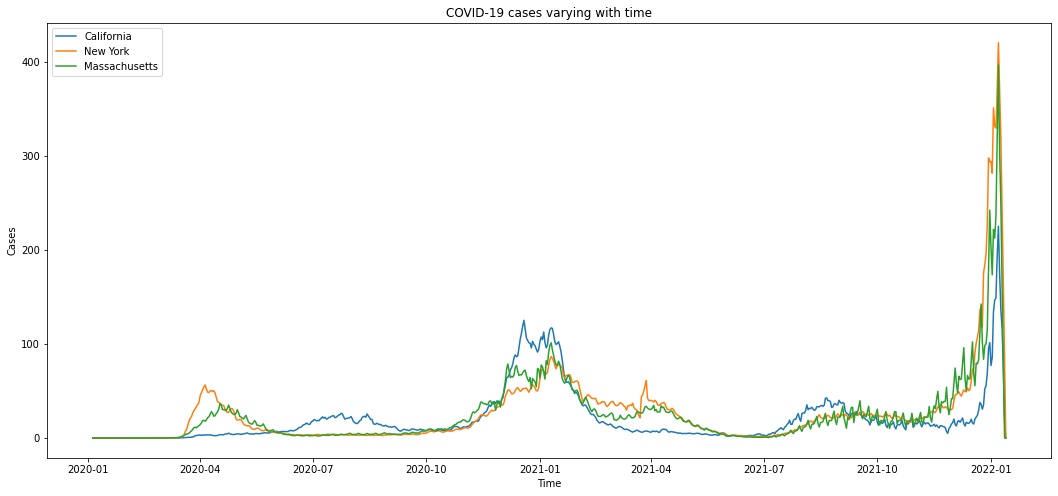

In [ ]:
fig = plt.subplots(1,1, figsize = (18,8))
plt.plot(california.index.values,cali_outcomes,label="California")
plt.plot(new_york.index.values,ny_outcomes,label="New York")
plt.plot(ma.index.values,ma_outcomes,label="Massachusetts")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('COVID-19 cases varying with time')
plt.legend()

## Data Imputation 

We imputed the remaining missing value in all features by using KNN imputer. 

In [ ]:
#imputation using KNN
col_names=cali_gt.columns
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(cali_gt)
imputed_data = imputer.transform(cali_gt)
imputed_cali_gt = pd.DataFrame(imputed_data,columns=col_names)

col_names=ny_gt.columns
imputer.fit(ny_gt)
imputed_data = imputer.transform(ny_gt)
imputed_ny_gt = pd.DataFrame(imputed_data,columns=col_names)

col_names=ma_gt.columns
imputer.fit(ma_gt)
imputed_data = imputer.transform(ma_gt)
imputed_ma_gt = pd.DataFrame(imputed_data,columns=col_names)

## Feature Correlation Test

We calculated Spearman correlation between features and cases to have an idea of which features are mostly correlated with or even potentially predictive to the number of COVID-19 cases. We found gt features are highly correlated with each other.

We then visualized the correlations between the google trend features by heatmap. We found Bronchitis and Cough appears to be highly correlated (corr>0.95).

In [ ]:
#Find gt features highly correlated with each other
gt_features=[imputed_cali_gt, imputed_ny_gt, imputed_ma_gt]
states=['California', 'New York', 'Massachusetts']
for i in range(3):
  cor_matrix = gt_features[i].corr().abs()
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  to_drop_column = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
  to_drop_row = [row for row in upper_tri if any(upper_tri.loc[row,] > 0.95)]

  print(states[i]+":")
  for col in to_drop_column:
    print(col)
    print(upper_tri[upper_tri[col]>0.95].index)
  print('\n')

California:
gt2_Bronchitis
Index(['gt2_Acute bronchitis'], dtype='object')
gt2_Cough
Index(['gt2_Bronchitis'], dtype='object')
gt2_Facial nerve paralysis
Index(['gt2_Bell's palsy'], dtype='object')
gt2_Sore throat
Index(['gt2_Cough'], dtype='object')


New York:
gt2_Bronchitis
Index(['gt2_Acute bronchitis'], dtype='object')
gt2_Facial nerve paralysis
Index(['gt2_Bell's palsy'], dtype='object')
gt2_Sore throat
Index(['gt2_Cough'], dtype='object')
gt2_Type 2 diabetes
Index(['gt2_Diabetes'], dtype='object')


Massachusetts:
gt2_Bronchitis
Index(['gt2_Acute bronchitis'], dtype='object')
gt2_Facial nerve paralysis
Index(['gt2_Bell's palsy'], dtype='object')
gt2_Sinusitis
Index(['gt2_Nasal congestion'], dtype='object')
gt2_Sore throat
Index(['gt2_Cough'], dtype='object')
gt2_Type 2 diabetes
Index(['gt2_Hypertension'], dtype='object')
gt2_Vaginal discharge
Index(['gt2_Bacterial vaginosis'], dtype='object')




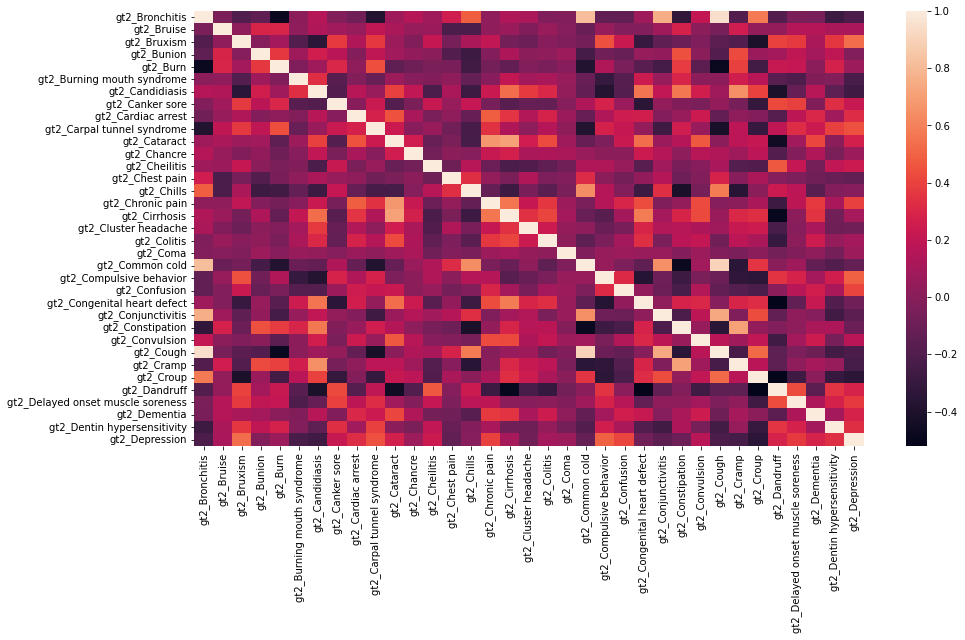

In [ ]:
#Display this heatmap to visualize the correlations between the google trend features
#One pair of highly correlated (corr>0.95) features which are Bronchitis and Cough appears in the figure
fig = plt.subplots(1,1, figsize = (15,8))
sns.heatmap(imputed_cali_gt.iloc[:,70:105].corr())

## Drop highly correlated features common among all three datasets

As a part of feature selection step, we dropped highly correlated features common among all three daatsets to reduce data dimensionallity, so as to reduce computation cost and improve model performance.

In [ ]:
#Drop highly correlated features common among all three datasets
imputed_cali_gt=imputed_cali_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)
imputed_ny_gt=imputed_ny_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)
imputed_ma_gt=imputed_ma_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)

In [ ]:
imputed_cali_gt.shape, imputed_ny_gt.shape, imputed_ma_gt.shape

((744, 356), (744, 356), (744, 356))

In [ ]:
cali_outcomes.shape, ny_outcomes.shape, ma_outcomes.shape

((744,), (744,), (744,))

# 3. Data Preparation for Time Series Forecasting

Since the gt features are in varies scales, we standardized the gt features by standard scaler.

In order to fit data into the RNN models, we first transformed two dimensional time-series data of shape [samples, features] into three dimensional structure of a shape [samples, time steps, features]. Specifically, we specified a time step of 14 days, then moved a sliding window of size [time steps, features] on the 2D dataset to capture the information for each time step and stacked them together to get a 3D data. Essentially, we add one dimension of time steps
to the original data. We defined the features as our predictors X, and the final 5-day COVID-19 cases for each 14-day period as our target Y, meaning that we used the features from every 14 days to predict the cases of the last 5 days. 

In [ ]:
def data_process(features, outcome):
    outcome = outcome.reset_index(drop = True)
    features = features.reset_index(drop = True)
    cols = features.columns
    standardizer = StandardScaler()
    standardizer.fit(features)
    scaled_features = pd.DataFrame(standardizer.transform(features),columns=cols)
    combo = pd.concat([scaled_features, outcome], axis = 1)
    combo["JHU_cases"] = combo["JHU_cases"].fillna(0)
    return combo

def times_series_split(time_series_df, response:str, days_train, days_pred, print_shape=False):
    
    # Initialize x, y arrays as zeroes
    # Decide if you want to hold out response variable
    x = np.zeros((0, days_train, time_series_df.shape[-1]-1))
    y = np.zeros((0, days_pred))
        
    # For every row in the dataframe
    for i in range(len(time_series_df)):
        
        # Define the windows of training and prediction
        idx_in = i + days_train
        idx_out = idx_in + days_pred
        
        # If window of prediction tries to go past end of data, stop
        if idx_out > len(time_series_df):
            break

        # Create windowed training sequence for all non-response columns
        seq_in = np.array(time_series_df.iloc[i:idx_in, time_series_df.columns != response])

        # Create windowed prediction sequence for response column
        response_idx = time_series_df.columns.get_loc(response)
        seq_out = np.array(time_series_df.iloc[idx_in:idx_out, response_idx])
        
        # Add sequences to respective array, shaped for supervised learning
        x = np.concatenate((x, seq_in.reshape(((1,)+seq_in.shape))), axis = 0)
        y = np.concatenate((y, seq_out.reshape(((1,)+seq_out.shape))), axis = 0)
        
    # Decide if you want to print the output shape for clarity
    if print_shape == True:
        print("x_train shape: ", x.shape, "y_train shape: ", y.shape)
    return np.array(x), np.array(y)

In [ ]:
ca_combo = data_process(imputed_cali_gt, cali_outcomes)
ny_combo = data_process(imputed_ny_gt, ny_outcomes)
ma_combo = data_process(imputed_ma_gt, ma_outcomes)

In [ ]:
days_train = 14
days_pred = 5
X_ca, y_ca = times_series_split(ca_combo, "JHU_cases", days_train, days_pred)
X_ny, y_ny = times_series_split(ny_combo, "JHU_cases", days_train, days_pred)
X_ma, y_ma = times_series_split(ma_combo, "JHU_cases", days_train, days_pred)
features_ca = X_ca.shape[-1]
features_ny = X_ny.shape[-1]
features_ma = X_ma.shape[-1]

In [ ]:
X_ca.shape, y_ca.shape

((726, 14, 356), (726, 5))

# 4. Recurrent Models for Forecasting COVID-19 New Cases

## Baseline Model - Simple RNN

As a baseline, we built a simple Recurrent Neural Networks (RNNs) model with a single 100 units layer to forecast the COVID-19 case number in the future, because RNNs are not only relatively easy to implement but also able to automatically learn the temporal dependencies.

## Advanced Models - LSTM & BiLSTM

LSTM is specifically designed for sequence data. It reads one time step of the sequence at a time and builds up an internal state representation that can be used as a learned context for making a prediction. Bidirectional LSTM can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations. Therefore, we first designed a single layer LSTM model with 100 units, and then tried a bidirectional LSTM model with a single LSTM layer wrapped by a bidirectional wrapper layer.

## Design

We used ReLU activation function on each hidden layer, Adam optimizer with 0.001 learning rate, and Mean Square Error (MSE) loss. To make the models comparable, we only used California dataset. We trained models with 80% training data, and validated the model with 20% validation data. After training the models, we visualized training loss and validation loss at each epoch to see clear decreasing trends. Then we used the trained models to make predictions and visualized the prediction performance overlapped with the true cases.

In [ ]:
# Define RNN model
def model_rnn(days_train, days_pred, features, summary=True):
    
    rnn = Sequential()
    # rnn.add(SimpleRNN(100, input_shape=(days_train, features), return_sequences=True))
    rnn.add(SimpleRNN(100, input_shape=(days_train, features), return_sequences=False))
    rnn.add(Dense(days_pred, activation="linear"))
    
    rnn.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        rnn.summary()
    
    return rnn

# Define LSTM model
def model_lstm(days_train, days_pred, features, summary=True):

    lstm = Sequential()
    lstm.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(days_train, features)))
    lstm.add(Dense(days_pred, activation="linear"))
    
    lstm.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        lstm.summary()
    
    return lstm

# Define Bidirectional LSTM model
def model_lstm_bd(days_train, days_pred, features, summary=True):

    lstm_bd = Sequential()
    lstm_bd.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(days_train, features)))
    lstm_bd.add(Dense(days_pred, activation="linear"))
    
    lstm_bd.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        lstm_bd.summary()
    
    return lstm_bd

# Define function to train an inputted model
def fit_model(model, x_train, y_train, val_split=0.0, epochs=10, verbose=1, batch_size=1, cb = []):
    history = model.fit(x_train, y_train, validation_split=val_split,
                        epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks = cb)
    return history

# Define function to plot single-day prediction
def plot_prediction(prediction, y_train, scale_max, ax=None):
    
    # Rescale data
    prediction_rescaled = prediction * scale_max
    y_train_rescaled = y_train * scale_max

    # Plot figure
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))

    plot_loc.plot(y_train_rescaled, label="Actual")
    plot_loc.plot(prediction_rescaled, ls='--', label="Prediction")
    
    if ax is None:
        plt.legend(fontsize=15, loc=2)
        # plt.title(f"Plotting {response} over time", size=20)
        plt.xlabel("Days since first case", size=15)

# Define function to allow windowed prediction plotting
# when predicting multiple days into the future
def plot_multiday_predictions(y_train, predictions, scale_max, ax=None, skip = 1):

    # Rescale data
    predictions_rescaled = predictions * scale_max
    y_train_rescaled = y_train * scale_max
    
    # Plot actual data
    cas_obs = []
    for i in range(len(y_train_rescaled)):
        cas_obs.append(y_train_rescaled[i, 0])
    
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))
        
    plot_loc.plot(np.arange(0, len(cas_obs)), cas_obs, label = 'Observed')
    for i in range(len(predictions_rescaled)):
        if i % skip != 0:
            continue
        plot_loc.plot(np.arange(i, i+predictions_rescaled.shape[-1]), predictions_rescaled[i], c = 'orange')
        
    if ax is None:
        plt.legend(['Observed', 'Predicted'], fontsize=15, loc=2)

# Define function to predict
def predict_model(model, x_test):
    prediction = model.predict(x_test)
    return prediction

In [ ]:
# es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
lcall = LambdaCallback(on_epoch_end=lambda epoch, logs: print("epoch " + str(epoch) + ", loss " + str(logs['val_loss'])) if epoch % 20 == 0 else None)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               45700     
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 46,205
Trainable params: 46,205
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 2375.10546875
epoch 20, loss 2532.185546875
epoch 40, loss 2645.808837890625


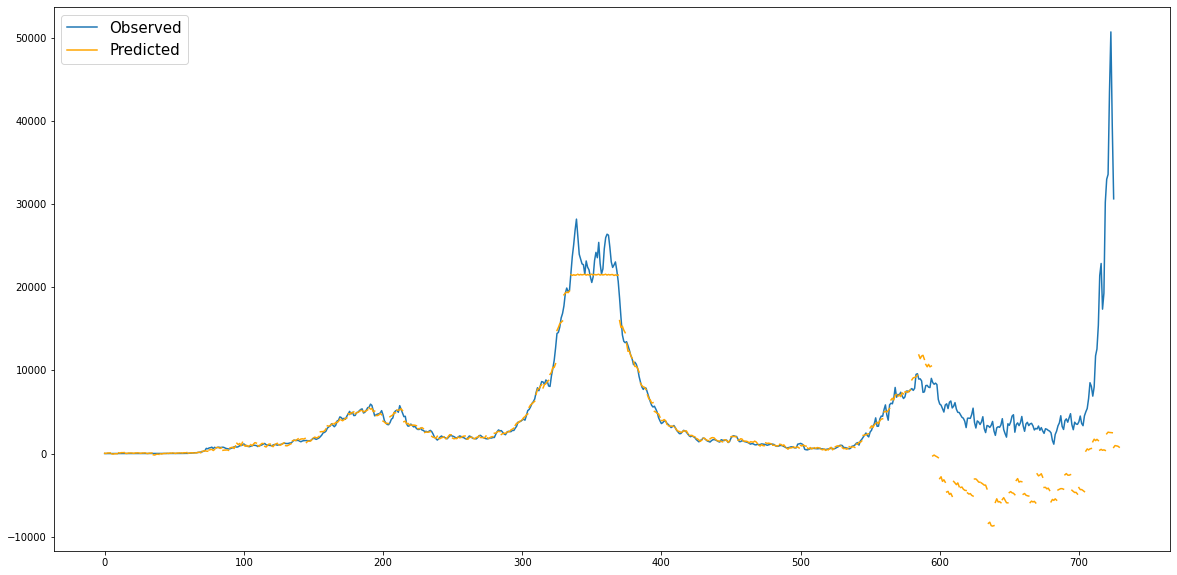

In [ ]:
# Simple RNN
rnn = model_rnn(days_train, days_pred, features_ca)
history_rnn = fit_model(rnn, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ca = predict_model(rnn, X_ca)
plot_multiday_predictions(y_ca, rnn_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 100)               182800    
                                                                 
 dense_25 (Dense)            (None, 5)                 505       
                                                                 
Total params: 183,305
Trainable params: 183,305
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1644.009521484375
epoch 20, loss 1096.5322265625
epoch 40, loss 1002.6178588867188


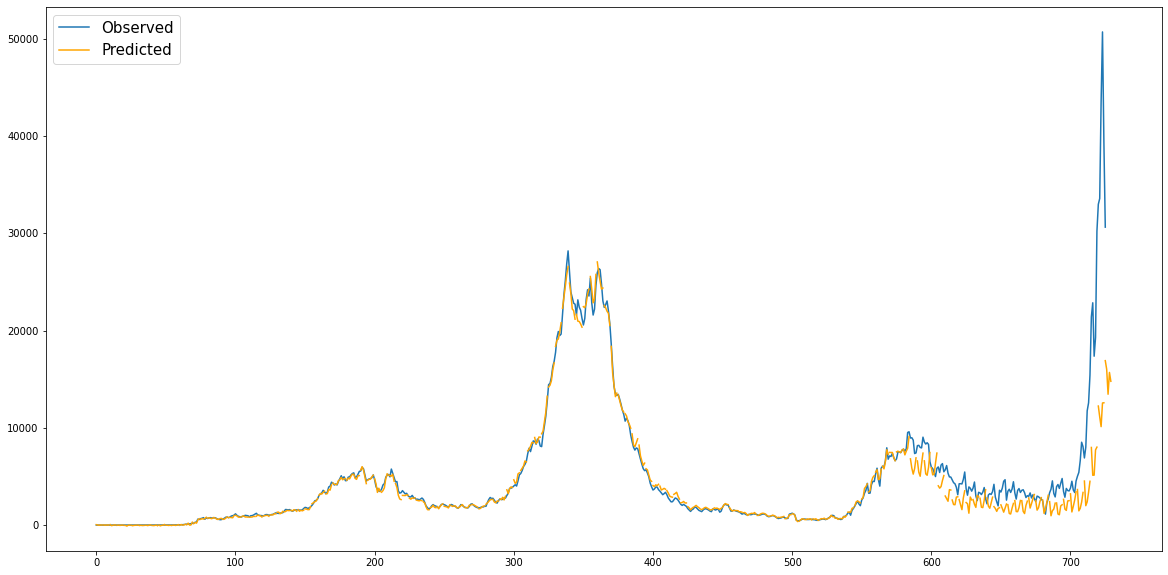

In [ ]:
# LSTM
lstm = model_lstm(days_train, days_pred, features_ca)
history_lstm = fit_model(lstm, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ca = predict_model(lstm, X_ca)
plot_multiday_predictions(y_ca, lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 200)              365600    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 366,605
Trainable params: 366,605
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1279.09326171875
epoch 20, loss 915.1183471679688
epoch 40, loss 925.269775390625


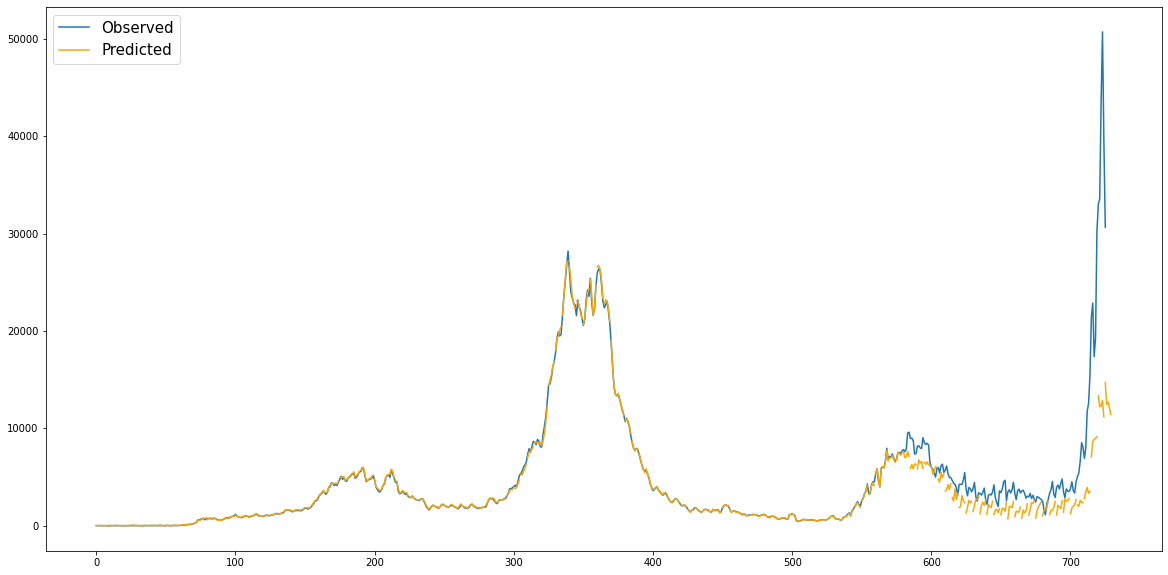

In [ ]:
# bidirectional LSTM
bd_lstm = model_lstm_bd(days_train, days_pred, features_ca)
history_bd_lstm = fit_model(bd_lstm, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ca = predict_model(bd_lstm, X_ca)
plot_multiday_predictions(y_ca, bd_lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

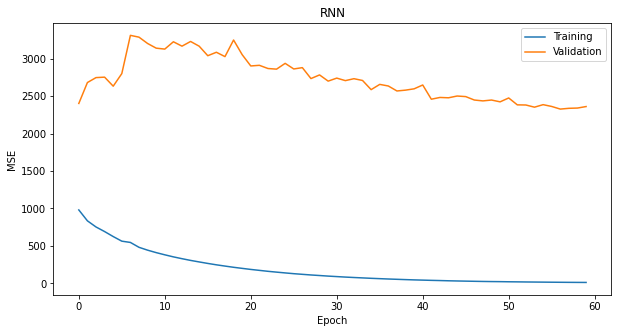

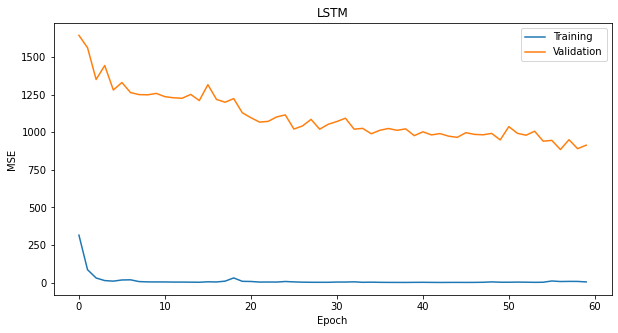

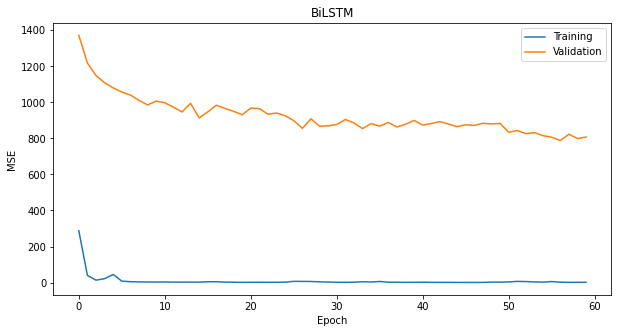

In [ ]:
def plot_training(history, title):
    plt.figure(figsize = (10,5))
    plt.plot(history.history['loss'], label = 'Training')
    plt.plot(history.history['val_loss'], label = 'Validation')
    plt.title(title)
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training(history_rnn, 'RNN')
plot_training(history_lstm, 'LSTM')
plot_training(history_bd_lstm, 'BiLSTM')

# 5. Cross-state Predictions

As expected, LSTM model and BiLSTM model overperformed the baseline simple RNN model, and BiLSTM performed the best. We further trained separate models on the Massachusetts dataset and New York dataset, because we hypothesized that different states have slightly different characteristics and patterns, and thus building separate models rather than generalized model would be useful for predicting new cases of a specific state.  

With the trained models, we were curious about whether our hypothesis is correct, that is, there is non-negligible difference in the features of different states, which could be captured by state-specific models. We tested our hypoethsis by cross predictions.

For the cross prediction part, we built separate BiLSTM models by using CA, NY, MA datasets. Then we used each of these models to forecast cases for all of the three states. We visualized the forecasted trend overlaped with the true case trend, and visualized validation MSE losses in a 3 by 3 heatmap.

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 200)              365600    
 nal)                                                            
                                                                 
 dense_22 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 366,605
Trainable params: 366,605
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1296.96142578125
epoch 20, loss 1012.5115356445312
epoch 40, loss 1029.8829345703125
Validation loss (CA model on CA data): 187.1203
Validation loss (CA model on NY data): 1869.5932
Validation loss (CA model on MA data): 1101.1275


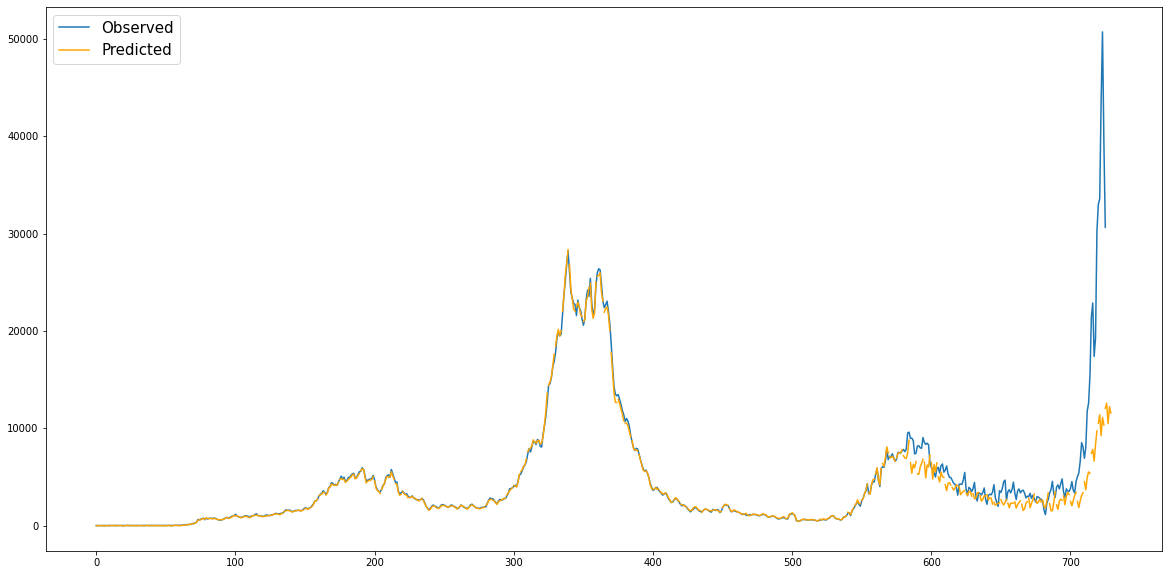

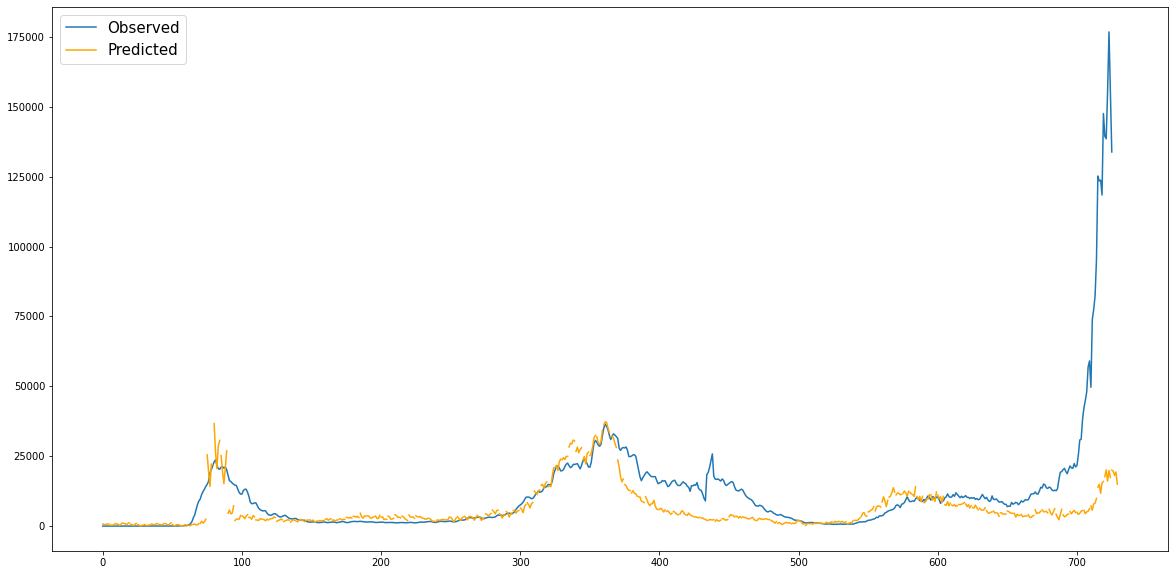

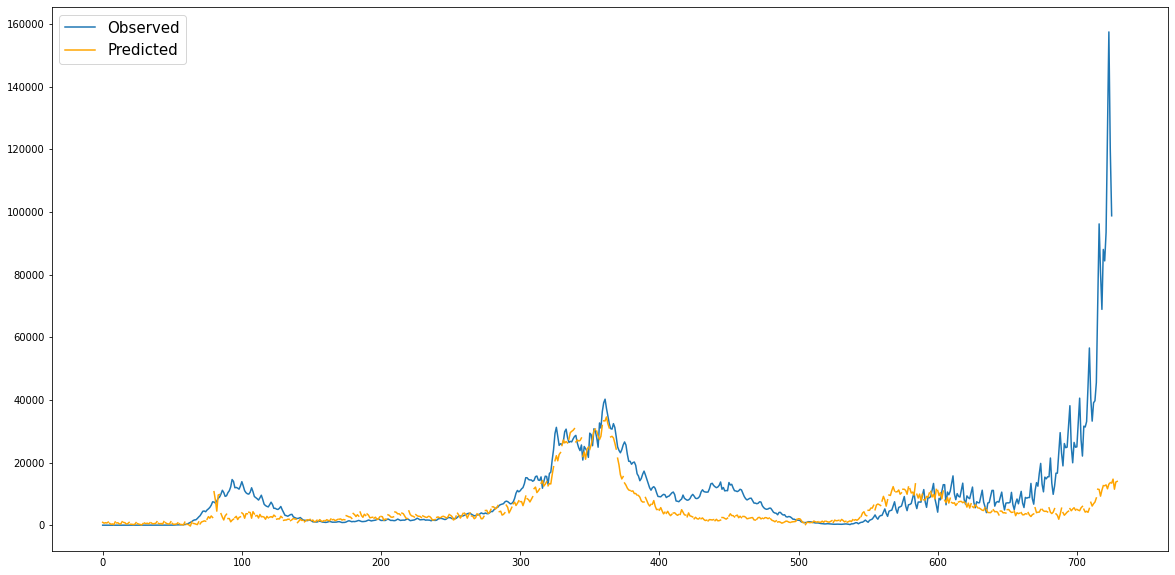

In [ ]:

bd_lstm_ca = model_lstm_bd(days_train, days_pred, features_ca)
history_bd_lstm_ca = fit_model(bd_lstm_ca, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)

# ca preds ca
bd_lstm_pred_ca = predict_model(bd_lstm_ca, X_ca)
ca_ca = mean_squared_error(bd_lstm_pred_ca, y_ca)
ca_ca600 = mean_squared_error(bd_lstm_pred_ca[:600,], y_ca[:600,])
plot_multiday_predictions(y_ca, bd_lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)
print(f"Validation loss (CA model on CA data): {ca_ca:.4f}")

# ca preds ny
bd_lstm_pred_ny = predict_model(bd_lstm_ca, X_ny)
ca_ny = mean_squared_error(bd_lstm_pred_ny, y_ny)
ca_ny600 = mean_squared_error(bd_lstm_pred_ny[:600,], y_ny[:600,])
plot_multiday_predictions(y_ny, bd_lstm_pred_ny, max(ny_combo['JHU_cases']), skip = 5)
print(f"Validation loss (CA model on NY data): {ca_ny:.4f}")

# ca preds ma
bd_lstm_pred_ma = predict_model(bd_lstm_ca, X_ma)
ca_ma = mean_squared_error(bd_lstm_pred_ma, y_ma)
ca_ma600 = mean_squared_error(bd_lstm_pred_ma[:600,], y_ma[:600,])
plot_multiday_predictions(y_ma, bd_lstm_pred_ma, max(ma_combo['JHU_cases']), skip = 5)
print(f"Validation loss (CA model on MA data): {ca_ma:.4f}")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 200)              365600    
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 366,605
Trainable params: 366,605
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 10163.53125
epoch 20, loss 9413.4140625
epoch 40, loss 9410.1328125
Validation loss (NY model on CA data): 458.0526
Validation loss (NY model on NY data): 1814.2366
Validation loss (NY model on MA data): 1096.3625


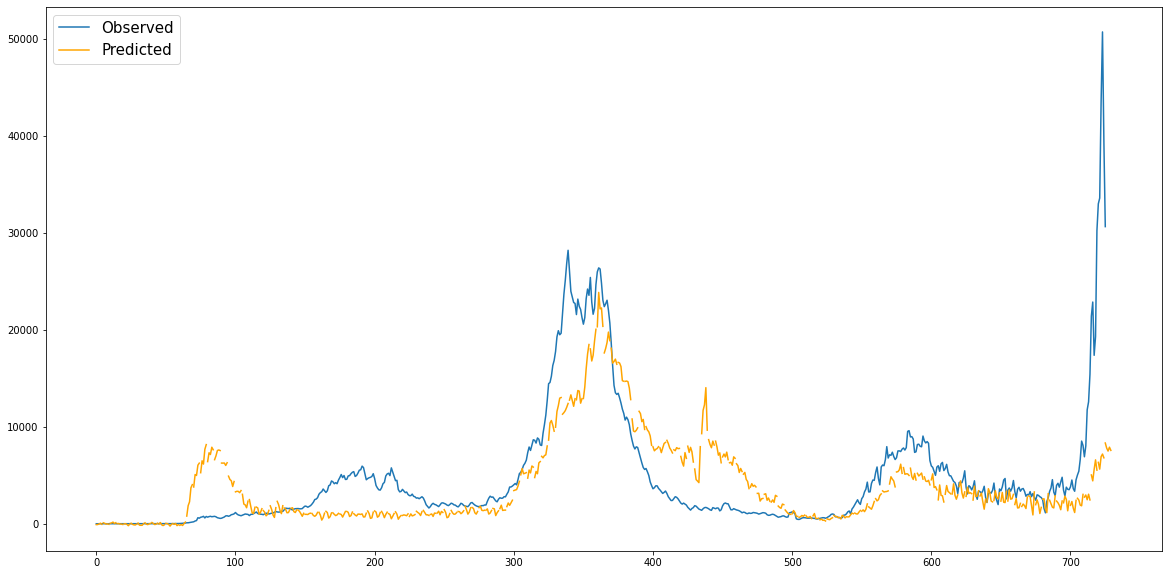

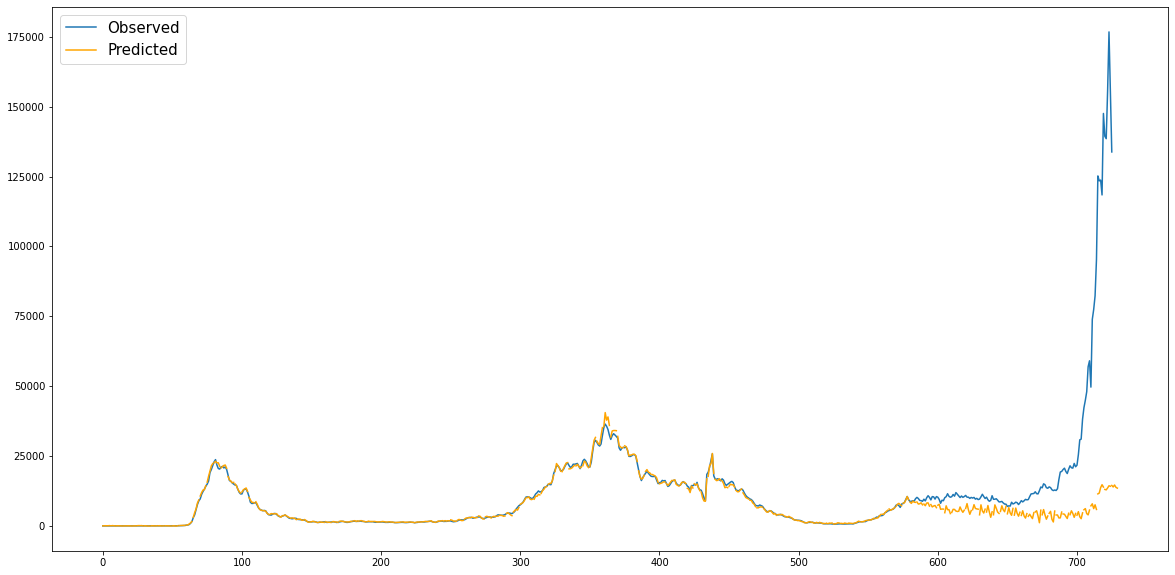

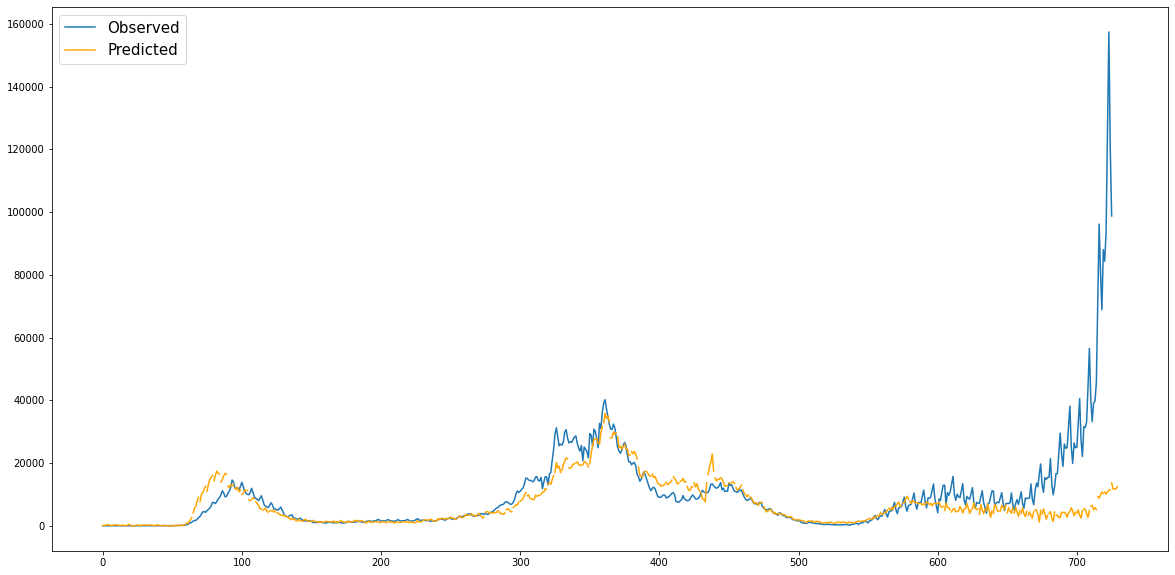

In [ ]:
bd_lstm_ny = model_lstm_bd(days_train, days_pred, features_ny)
history_bd_lstm_ny = fit_model(bd_lstm_ny, X_ny, y_ny, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)

# ny preds ca
bd_lstm_pred_ca = predict_model(bd_lstm_ny, X_ca)
ny_ca = mean_squared_error(bd_lstm_pred_ca, y_ca)
ny_ca600 = mean_squared_error(bd_lstm_pred_ca[:600,], y_ca[:600,])
plot_multiday_predictions(y_ca, bd_lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)
print(f"Validation loss (NY model on CA data): {ny_ca:.4f}")

# ny preds ny
bd_lstm_pred_ny = predict_model(bd_lstm_ny, X_ny)
ny_ny = mean_squared_error(bd_lstm_pred_ny, y_ny)
ny_ny600 = mean_squared_error(bd_lstm_pred_ny[:600,], y_ny[:600,])
plot_multiday_predictions(y_ny, bd_lstm_pred_ny, max(ny_combo['JHU_cases']), skip = 5)
print(f"Validation loss (NY model on NY data): {ny_ny:.4f}")

# ny preds ma
bd_lstm_pred_ma = predict_model(bd_lstm_ny, X_ma)
ny_ma = mean_squared_error(bd_lstm_pred_ma, y_ma)
ny_ma600 = mean_squared_error(bd_lstm_pred_ma[:600,], y_ma[:600,])
plot_multiday_predictions(y_ma, bd_lstm_pred_ma, max(ma_combo['JHU_cases']), skip = 5)
print(f"Validation loss (NY model on MA data): {ny_ma:.4f}")

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 200)              365600    
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 366,605
Trainable params: 366,605
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 5808.275390625
epoch 20, loss 5658.80712890625
epoch 40, loss 5426.98095703125
Validation loss (MA model on CA data): 402.3404
Validation loss (MA model on NY data): 1913.6523
Validation loss (MA model on MA data): 1094.7579


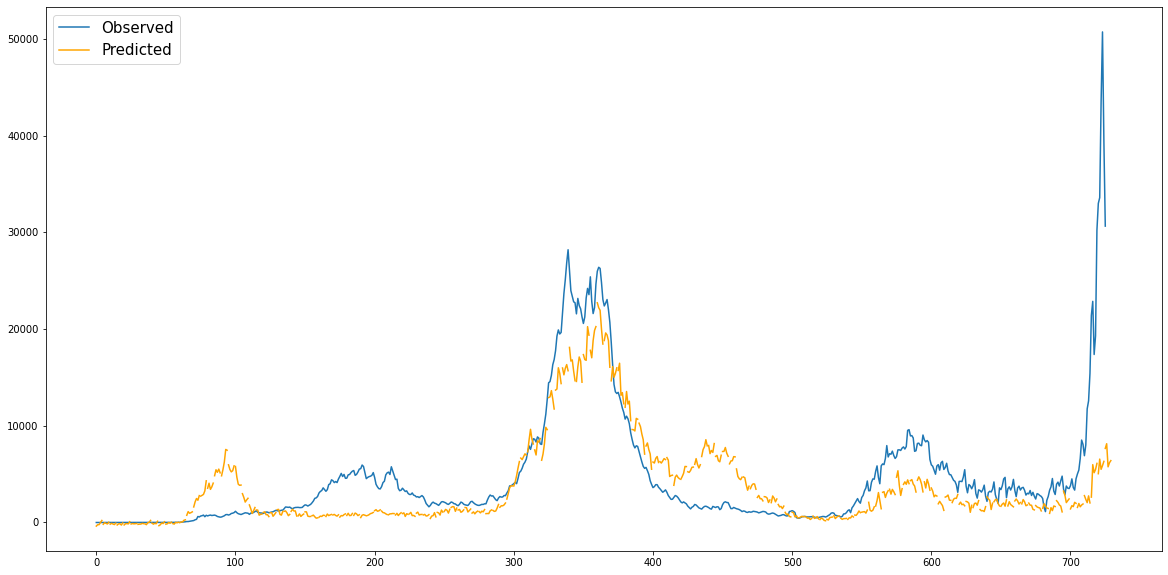

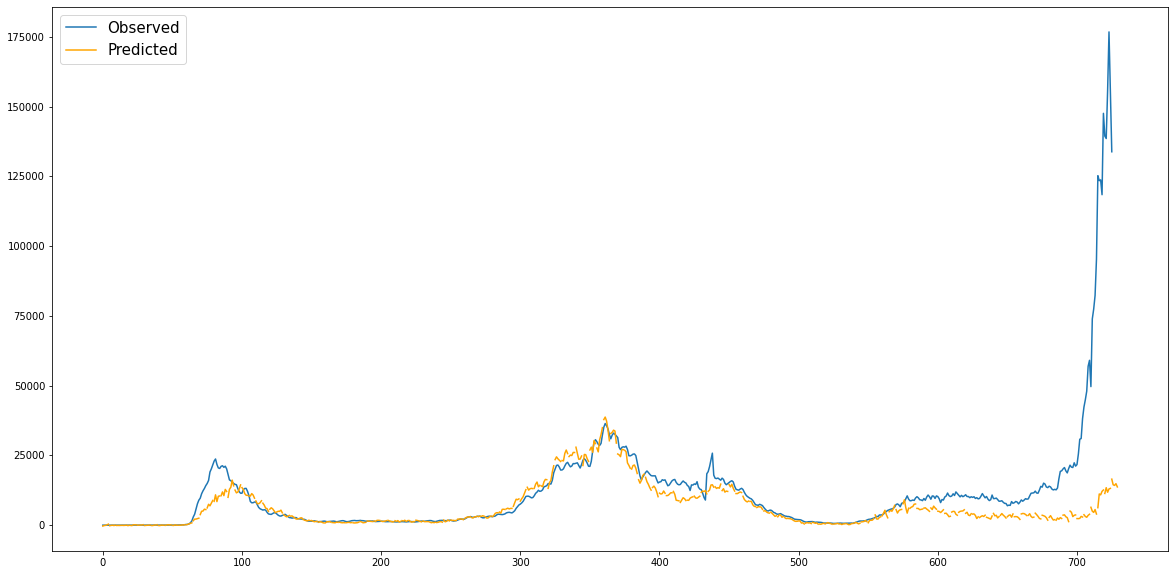

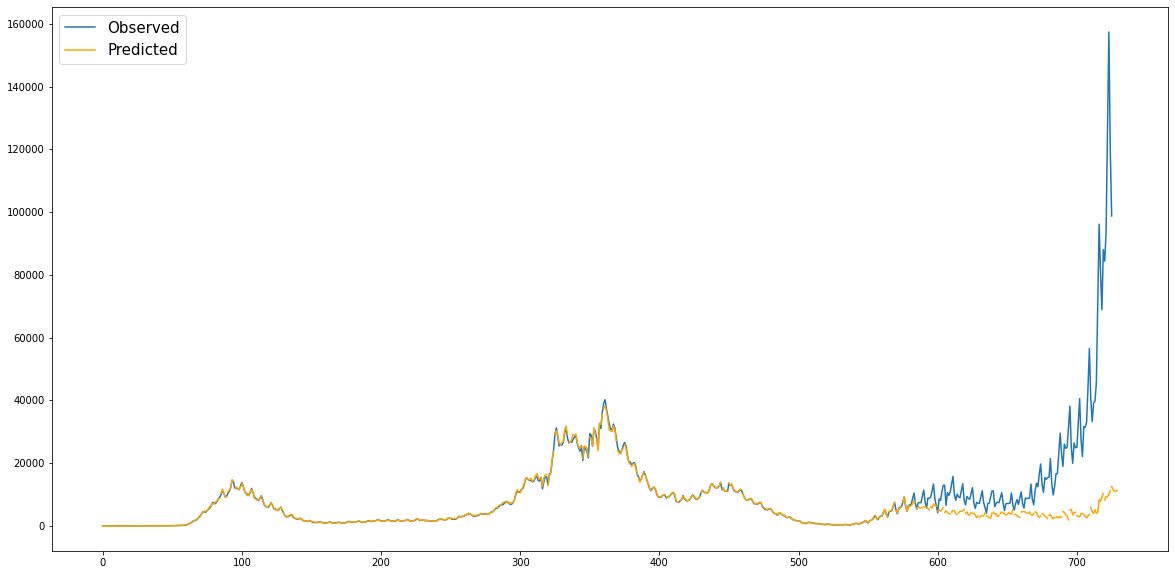

In [ ]:
bd_lstm_ma = model_lstm_bd(days_train, days_pred, features_ma)
history_bd_lstm_ma = fit_model(bd_lstm_ma, X_ma, y_ma, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)

# ma preds ca
bd_lstm_pred_ca = predict_model(bd_lstm_ma, X_ca)
ma_ca = mean_squared_error(bd_lstm_pred_ca, y_ca)
ma_ca600 = mean_squared_error(bd_lstm_pred_ca[:600,], y_ca[:600,])
plot_multiday_predictions(y_ca, bd_lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)
print(f"Validation loss (MA model on CA data): {ma_ca:.4f}")

# ma preds ny
bd_lstm_pred_ny = predict_model(bd_lstm_ma, X_ny)
ma_ny = mean_squared_error(bd_lstm_pred_ny, y_ny)
ma_ny600 = mean_squared_error(bd_lstm_pred_ny[:600,], y_ny[:600,])
plot_multiday_predictions(y_ny, bd_lstm_pred_ny, max(ny_combo['JHU_cases']), skip = 5)
print(f"Validation loss (MA model on NY data): {ma_ny:.4f}")

# ma preds ma
bd_lstm_pred_ma = predict_model(bd_lstm_ma, X_ma)
ma_ma = mean_squared_error(bd_lstm_pred_ma, y_ma)
ma_ma600 = mean_squared_error(bd_lstm_pred_ma[:600,], y_ma[:600,])
plot_multiday_predictions(y_ma, bd_lstm_pred_ma, max(ma_combo['JHU_cases']), skip = 5)
print(f"Validation loss (MA model on MA data): {ma_ma:.4f}")

## Visualize validation MSE loss in heatmaps

The first heatmap shows that all three models performed better on the forecasting cases in California. This can be explained by the fact the there is no serious outbreak of pandemics in CA at the end of the 2021, but there is an exponential growth in MA and NY at that time. Since the models are weak in forecasting this sudden outbreak in MA and NY, the overall validation losses on MA and NY datasets are higher than expected.

We further removed the losses from the last ~100 days for all three models and produced the second heatmap. It clearly shows that the models learned state-specific features and performed better on specific states.

        CA    NY    MA
model                 
CA     187  1870  1101
NY     458  1814  1096
MA     402  1914  1095


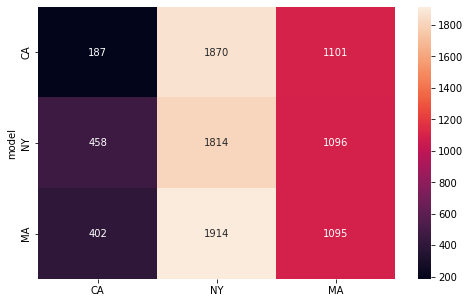

In [ ]:

matrix = pd.DataFrame({'model': ['CA', 'NY','MA'],
                       "CA": [round(ca_ca), round(ny_ca), round(ma_ca)], 
                       "NY": [round(ca_ny), round(ny_ny), round(ma_ny)], 
                       "MA": [round(ca_ma), round(ny_ma), round(ma_ma)]}).set_index('model')
print(matrix)
fig, ax = plt.subplots(1,1, figsize = (8,5))
_ = sns.heatmap(matrix, annot = True, fmt = 'd')

          CA     NY     MA
model                     
CA       4.0  170.9  116.6
NY     264.7    3.0   55.5
MA     174.3   47.7    2.8


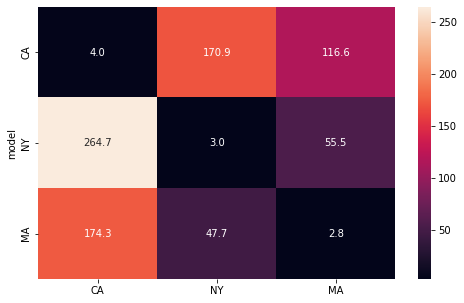

In [ ]:
# first 600 days

matrix = pd.DataFrame({'model': ['CA', 'NY','MA'],
                       "CA": [round(ca_ca600, 1), round(ny_ca600, 1), round(ma_ca600, 1)], 
                       "NY": [round(ca_ny600, 1), round(ny_ny600, 1), round(ma_ny600, 1)], 
                       "MA": [round(ca_ma600, 1), round(ny_ma600, 1), round(ma_ma600, 1)]}).set_index('model')
print(matrix)
fig, ax = plt.subplots(1,1, figsize = (8,5))
_ = sns.heatmap(matrix, annot = True, fmt = '.1f')

# 6. Calculate feature importance measured by Mean Absolute Error (MAE) through shuffling features on at a time in LSTM models

Reference: https://www.kaggle.com/code/cdeotte/lstm-feature-importance/notebook

In [ ]:
def feature_importance(model, X_ca, y_ca, COLS, top_num, model_name, results = None):
    
    if not results:
        results = []
        print(' Computing feature importance...')

        # COMPUTE BASELINE (NO SHUFFLE)
        base_preds = predict_model(model, X_ca)
        baseline_mae = mean_absolute_error(base_preds, y_ca)
        results.append({'feature':'BASELINE','mae':baseline_mae}) 

        for k in range(len(COLS)):            
            # SHUFFLE FEATURE K
            save_col = X_ca[:,:,k].copy()
            np.random.shuffle(X_ca[:,:,k])
                                    
            # COMPUTE prediction MAE WITH FEATURE K SHUFFLED
            shuf_preds = predict_model(model, X_ca)
            #   mae = np.mean(np.abs( shuf_preds-y_ca ))
            mae = mean_absolute_error(shuf_preds, y_ca)
            results.append({'feature':COLS[k],'mae':mae})
            X_ca[:,:,k] = save_col
    else:
        # COMPUTE BASELINE (NO SHUFFLE)
        base_preds = predict_model(model, X_ca)
        baseline_mae = mean_absolute_error(base_preds, y_ca)
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    df = df.reset_index(drop = True)[-top_num:]
    plt.figure(figsize=(5,8))
    plt.barh(np.arange(len(df)),df.mae)
    plt.yticks(np.arange(len(df)),df.feature.values)
    plt.title(model_name + 'Feature Importance',size=16)
    plt.ylim((-1,len(df)))
    plt.plot([baseline_mae, baseline_mae],[-1,len(df)], '--', color='orange',label=f'Baseline \nMAE={baseline_mae:.3f}')
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
    return results

**Bidirectional LSTM**

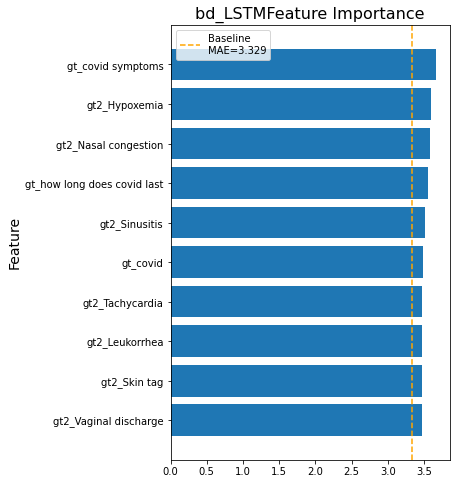

In [ ]:
re_bd_lstm = feature_importance(bd_lstm, X_ca, y_ca, list(imputed_cali_gt.columns), 10, "bd_LSTM", re_bd_lstm)

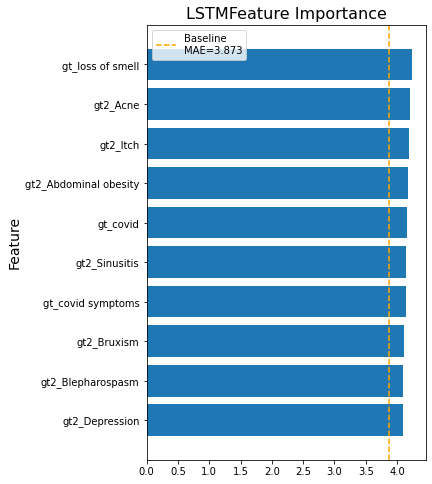

In [ ]:
re_lstm = feature_importance(lstm, X_ca, y_ca, list(imputed_cali_gt.columns), 10, "LSTM", re_lstm)

# 7. Prediction with and without COVID terms

We noticed that some of the most predictive features from the feature importance section include COVID-19 related terms (covid, sars, vaccine). When COVID-19 first appeared, it was not named officially. Including COVID-19 terms introduce some lagging bias. Besides, using COVID-19 related terms for case prediction could not generalize to other infectious disease outbreak. Therefore, we train the SimpleRNN, LSTM, and bidirectional-LSTM on both data with COVID-19 terms (356) and without COVID-19 terms (346). We plot the validation loss comparison for each model, as well as important features. 

In [ ]:
len(ca_combo_filtered.columns)

346

In [ ]:
to_filter = [i for i in list(imputed_cali_gt.columns) if "cov" in i or "sars" in i or "vaccine" in i]

In [ ]:
to_filter

['gt_after covid vaccine',
 'gt_side effects of vaccine',
 'gt_effects of covid vaccine',
 'gt_covid',
 'gt_how long does covid last',
 'gt_covid-19',
 'gt_covid symptoms',
 'gt_sars-cov 2',
 'gt_covid nhs',
 'gt_covid-19 who',
 'gt_sars-cov-2 ']

In [ ]:
ca_combo_filtered = ca_combo.drop(to_filter, axis = 1)
ma_combo_filtered = ma_combo.drop(to_filter, axis = 1)
ny_combo_filtered = ny_combo.drop(to_filter, axis = 1)

days_train = 14
days_pred = 5
X_ca, y_ca = times_series_split(ca_combo, "JHU_cases", days_train, days_pred)
X_ny, y_ny = times_series_split(ny_combo, "JHU_cases", days_train, days_pred)
X_ma, y_ma = times_series_split(ma_combo, "JHU_cases", days_train, days_pred)
features_ca = X_ca.shape[-1]
features_ny = X_ny.shape[-1]
features_ma = X_ma.shape[-1]

X_ca_f, y_ca_f = times_series_split(ca_combo_filtered, "JHU_cases", days_train, days_pred)
X_ny_f, y_ny_f = times_series_split(ny_combo_filtered, "JHU_cases", days_train, days_pred)
X_ma_f, y_ma_f = times_series_split(ma_combo_filtered, "JHU_cases", days_train, days_pred)
features_ca_f = X_ca_f.shape[-1]
features_ny_f = X_ny_f.shape[-1]
features_ma_f = X_ma_f.shape[-1]

In [ ]:
lcall = LambdaCallback(on_epoch_end=lambda epoch, logs: print("epoch " + str(epoch) + ", loss " + str(logs['val_loss'])) if epoch % 20 == 0 else None)

In [ ]:
rnn = model_rnn(days_train, days_pred, features_ca)
history_rnn = fit_model(rnn, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ca = predict_model(rnn, X_ca)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 100)               45700     
                                                                 
 dense_16 (Dense)            (None, 5)                 505       
                                                                 
Total params: 46,205
Trainable params: 46,205
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 2403.7138671875
epoch 20, loss 2904.694580078125
epoch 40, loss 2650.36328125


In [ ]:
rnn_f = model_rnn(days_train, days_pred, features_ca_f)
history_rnn_f = fit_model(rnn_f, X_ca_f, y_ca_f, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ca_f = predict_model(rnn_f, X_ca_f)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 100)               44600     
                                                                 
 dense_17 (Dense)            (None, 5)                 505       
                                                                 
Total params: 45,105
Trainable params: 45,105
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 2430.437744140625
epoch 20, loss 3046.705810546875
epoch 40, loss 2758.72998046875


In [ ]:
# bidirectional LSTM
bd_lstm = model_lstm_bd(days_train, days_pred, features_ca)
history_bd_lstm = fit_model(bd_lstm, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ca = predict_model(bd_lstm, X_ca)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 200)              365600    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 366,605
Trainable params: 366,605
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1371.815185546875
epoch 20, loss 967.8653564453125
epoch 40, loss 873.6837768554688


In [ ]:
# bidirectional LSTM
bd_lstm_f = model_lstm_bd(days_train, days_pred, features_ca_f)
history_bd_lstm_f = fit_model(bd_lstm_f, X_ca_f, y_ca_f, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ca_f = predict_model(bd_lstm_f, X_ca_f)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 200)              356800    
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 357,805
Trainable params: 357,805
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1030.4554443359375
epoch 20, loss 845.8502197265625
epoch 40, loss 852.872802734375


In [ ]:
# LSTM
lstm = model_lstm(days_train, days_pred, features_ca)
history_lstm = fit_model(lstm, X_ca, y_ca, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ca = predict_model(lstm, X_ca)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100)               182800    
                                                                 
 dense_20 (Dense)            (None, 5)                 505       
                                                                 
Total params: 183,305
Trainable params: 183,305
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1465.98486328125
epoch 20, loss 841.5027465820312
epoch 40, loss 906.6080932617188


In [ ]:
# LSTM
lstm_f = model_lstm(days_train, days_pred, features_ca_f)
history_lstm_f = fit_model(lstm_f, X_ca_f, y_ca_f, val_split=0.2, epochs = 60, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ca_f = predict_model(lstm_f, X_ca_f)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 100)               178400    
                                                                 
 dense_21 (Dense)            (None, 5)                 505       
                                                                 
Total params: 178,905
Trainable params: 178,905
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 1404.454345703125
epoch 20, loss 1066.6693115234375
epoch 40, loss 1030.568115234375


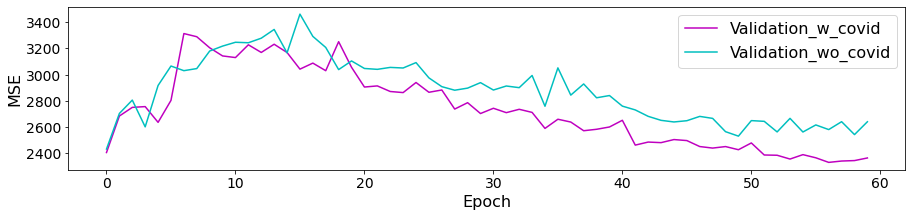

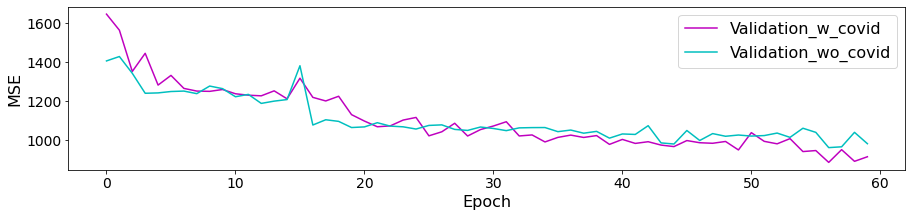

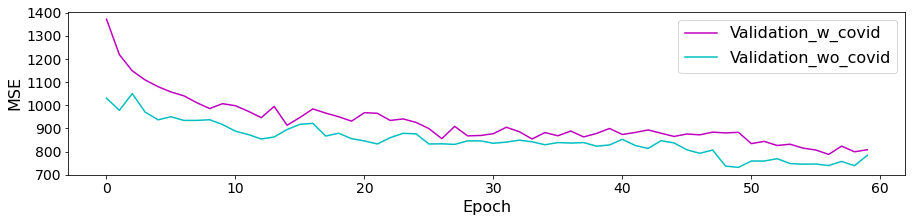

In [ ]:
plt.figure(figsize = (15,3))
plt.plot(history_rnn.history['val_loss'], label = 'Validation_w_covid', color = "m")
plt.plot(history_rnn_f.history['val_loss'], label = 'Validation_wo_covid', color = "c")
plt.ylabel('MSE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 16)
# plt.show()
plt.figure(figsize = (15,3))
plt.plot(history_lstm.history['val_loss'], label = 'Validation_w_covid', color = "m")
plt.plot(history_lstm_f.history['val_loss'], label = 'Validation_wo_covid', color = "c")
plt.ylabel('MSE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 16)
plt.figure(figsize = (15,3))
plt.plot(history_bd_lstm.history['val_loss'], label = 'Validation_w_covid', color = "m")
plt.plot(history_bd_lstm_f.history['val_loss'], label = 'Validation_wo_covid', color = "c")
plt.ylabel('MSE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 16)

 Computing feature importance...


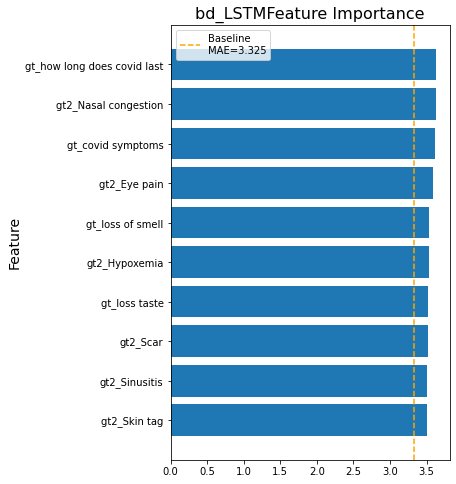

In [ ]:
re_bd_lstm = feature_importance(bd_lstm, X_ca, y_ca, list(imputed_cali_gt.columns), 10, "bd_LSTM", re_bd_lstm)

 Computing feature importance...


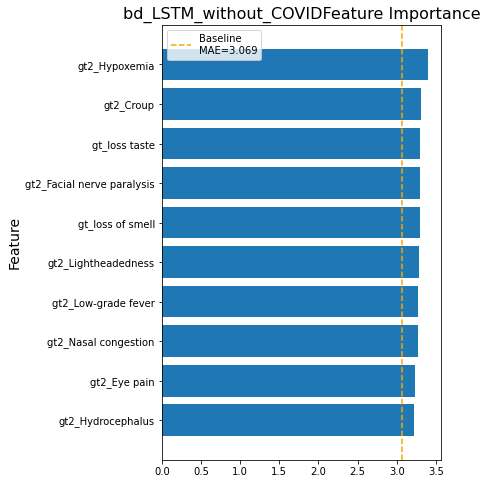

In [ ]:
re_bd_lstm_f = feature_importance(bd_lstm_f, X_ca_f, y_ca_f, list(ca_combo_filtered.columns)[:-1], 10, "bd_LSTM_without_COVID", re_bd_lstm_f)


# 8. Results and Discussion

We successfully trained LSTM and BiLSTM models on CA, MA, NY datasets, and achieved good performance on predicting 5-day COVID-19 confirmed cases based on 14-day gt features. We also demonstrated that they can provide better results than standard RNNs. However, the models perform poorly on the end. One reason is that the data collection date ends at a period where cases number soars to an unprecedented level. This sudden surge also explains the poor models' performance on New York and Massachusetts because New York and Massachusetts had a much more drastic lift on cases number than California. 

We show that the model built from one state could hardly generalize to the other two states by cross predicting cases on all of the three state datasets using state-specific BiLSTM models. This could be due to the fact that there are different characteristics among three states that contribute to the case trend. We then digged deeper into the features by identifying feature importance. 

Lastly, the model trained with COVID-19 terms perform similarly to the model trained without COVID-19 terms. The top 10 important features of the model **with** COV features include COVID-19 related terms (how long does covid last, covid symptoms) and COVID-19 symptoms (loss of smell, loss taste). The top 10 important feature of the model **without** COV features include a few COVID-19 symptoms (loss taste, loss of smell, etc.) and COVID-19 complications (Hypoxemia, Croup, etc.). The similarity on model performance confirm the models' generalizability. Potential outbreak early warning mechanism could be built upon our models. 

# 9. Strengths, Limitations, and Difficulties

One strength is our choice of neural network models. LSTM is specifically engineered and best-suited for forecasting future values based on previous, sequential data. Moreover, We have used a proxy model to identify importance features that contribute to forecasting cases.

Another strength is generalizability. The performance of the models trained with and without COVID-19 terms is similar, indicating that we are not necessarily relying on COVID-19 terms to do the prediction thereby the models can be generalized to other outbreak prediction. 

There are several limitations. First, the dataset only contains about 700 days of features and cases, which is not large enough for building a robust Neural Network model. For example, the data ends at a period when COVID-19 cases number soars to an unprecendented level. Our model built on the previous dates could not possibily predict the unprecedented dates well. The small dataset also prevent us to incorperate more interesting features such as clinical data and environmental data, since we would suffer from dimensionality curse with a large ratio of feature numbers and data rows. Second, there are a large number of missing values in potentially important features we are interested in. Third, we have limited time to build models for other states or explore more advanced model structures and methods. 

We have difficulties in forecasting a sudden outbreak of pandemic in MA and NY in the end of 2021. And we have limited time to address this issue by exploring other methods or upgrade our models. 

# 10. Future Work

For the future work, we will first overcome our limitations. We will continue to collect case data from JHU to enlarge the dataset. If the dataset is large enough, we will incorperate more interesting features from other sources such as anonymized mobile phones, Twitter microblogs, clinicians searches, weather, enviroment, emerging infectious diseases, etc. We will then consider methods to better deal with large missing values such as imputing NAs by doing regression on related features.

We have two directions to improve model performance in order to possibly address the diffculties mentioned above. First, we could define an outbreak by exponential growth and apply machine learning methods to predict the outbreak. Second, by literature review we noticed that LSTM and CNN layers are often combined when forecasting a time series. It turns out that CNN layer with dilated convolutions could provide subsequence interpretations for LSTM layer to account for sequential dependencies in the time series. So we would like to build a hybrid CNN-LSTM model to hopefully achieve a better performance.




# Reference:

Alassafi, Madini O et al. “Time series predicting of COVID-19 based on deep learning.” Neurocomputing vol. 468 (2022): 335-344. doi:10.1016/j.neucom.2021.10.035

Vahedi, B., Karimzadeh, M. & Zoraghein, H. Spatiotemporal prediction of COVID-19 cases using inter- and intra-county proxies of human interactions. Nat Commun 12, 6440 (2021). https://doi.org/10.1038/s41467-021-26742-6

Kogan, Nicole E et al. “An early warning approach to monitor COVID-19 activity with multiple digital traces in near real time.” Science advances vol. 7,10 eabd6989. 5 Mar. 2021, doi:10.1126/sciadv.abd6989